# Setup

### Setup dataset

In [36]:
from keras.datasets import mnist
from keras.utils import np_utils
(trainX, trainy), (testX, testy) = mnist.load_data()
trainX, testX = [x.reshape(x.shape[0], x.shape[1] * x.shape[2]) for x in [trainX, testX]]
trainY, testY = [np_utils.to_categorical(y, 10) for y in [trainy, testy]]

### Prepare helper function

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

def gen_model(weight_path=None):
    model = Sequential()
    model.add(Dense(100, input_shape=(784,)))
    model.add(Activation("relu"))
    model.add(Dense(10))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
    if weight_path:
        model.load_weights(weight_path)
    return model

Using Theano backend.


In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.subplot(221)
    plt.plot(np.arange(nb_epoch), history.history["loss"], color="r", label="loss")
    plt.subplot(222)
    plt.plot(np.arange(nb_epoch), history.history["val_loss"], color="b", label="val_loss")
    plt.subplot(223)
    plt.plot(np.arange(nb_epoch), history.history["acc"], color="g", label="acc")
    plt.subplot(224)
    plt.plot(np.arange(nb_epoch), history.history["val_acc"], color="y", label="val_acc")

In [38]:
from sklearn.metrics import classification_report

def evaluate_model(model, testX, testY):
    Yhat = model.predict(testX)
    yhat = np.argmax(Yhat, axis=1)
    print(classification_report(testy, yhat))

In [39]:
def visualize_weight(model, fig_size):
    plt.figure(figsize=(fig_size, fig_size))
    W1 =  model.layers[0].W.get_value(borrow=True).T
    for i in range(len(W1)):
        plt.subplot(10,10, i+1)
        plt.imshow(W1[i].reshape(28, 28), cmap="gray")
    plt.show()
    plt.figure(figsize=(fig_size, fig_size))
    W2 = model.layers[2].W.get_value(borrow=True).T
    for i in range(len(W2)):
        plt.subplot(10, 1, i+1)
        plt.imshow(W2[i].reshape(1, 100), cmap="gray")
    plt.show()

# Compare learning result with/without input scaling

### without input scaling
- pixcel value range is [0~255]

/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.77      0.98      0.86       980
          1       0.89      0.99      0.93      1135
          2       0.00      0.00      0.00      1032
          3       0.42      0.98      0.59      1010
          4       0.00      0.00      0.00       982
          5       0.00      0.00      0.00       892
          6       0.76      0.98      0.85       958
          7       0.00      0.00      0.00      1028
          8       0.70      0.94      0.80       974
          9       0.37      0.96      0.54      1009

avg / total       0.40      0.59      0.46     10000



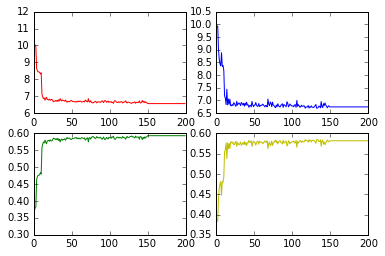

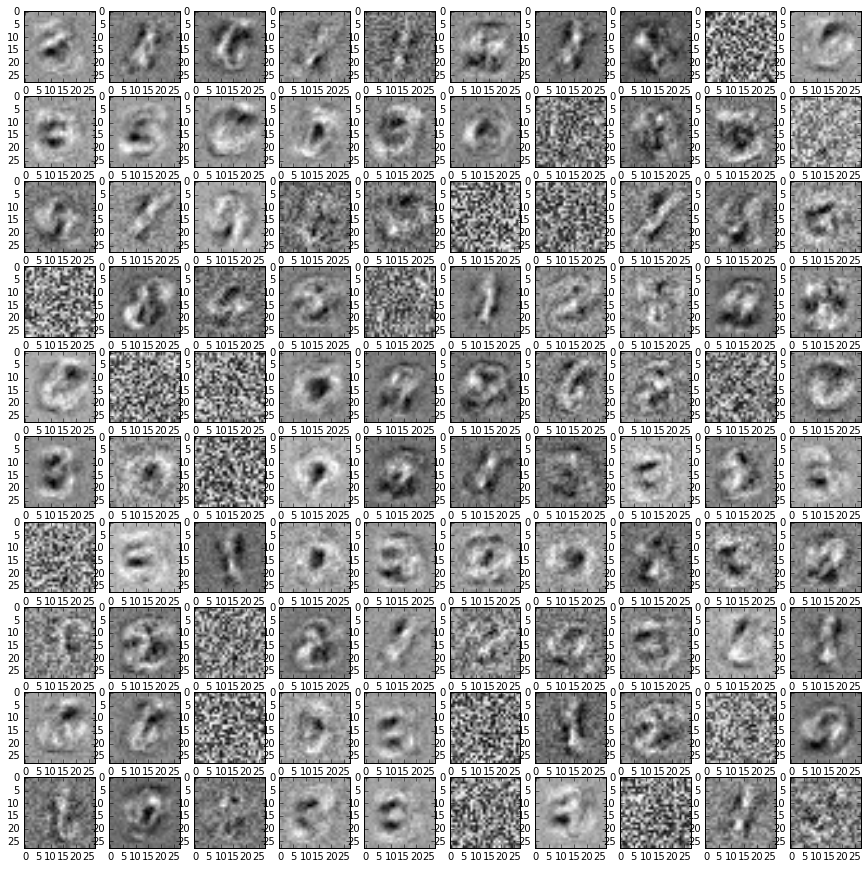

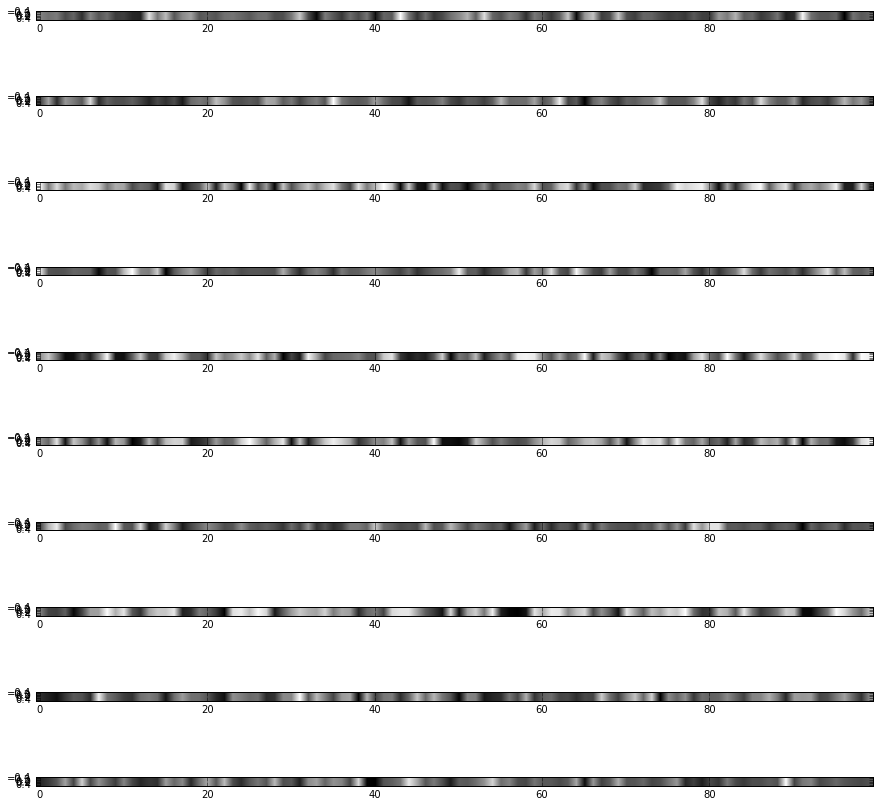

In [40]:
# Start training
model = gen_model()
nb_epoch = 200
history = model.fit(trainX, trainY, batch_size=128, nb_epoch=nb_epoch, verbose=0, validation_split=0.1)

# Show training summary
plot_training_history(history)
evaluate_model(model, testX, testY)
visualize_weight(model, fig_size=15)

### with input scaling
- pixcel value range is scaled down to [0~1]

In [41]:
# Scale input
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       980
          1       0.99      0.99      0.99      1135
          2       0.97      0.97      0.97      1032
          3       0.97      0.97      0.97      1010
          4       0.98      0.97      0.97       982
          5       0.98      0.97      0.97       892
          6       0.97      0.98      0.98       958
          7       0.97      0.97      0.97      1028
          8       0.97      0.97      0.97       974
          9       0.97      0.96      0.97      1009

avg / total       0.97      0.97      0.97     10000



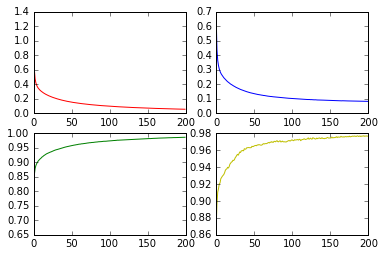

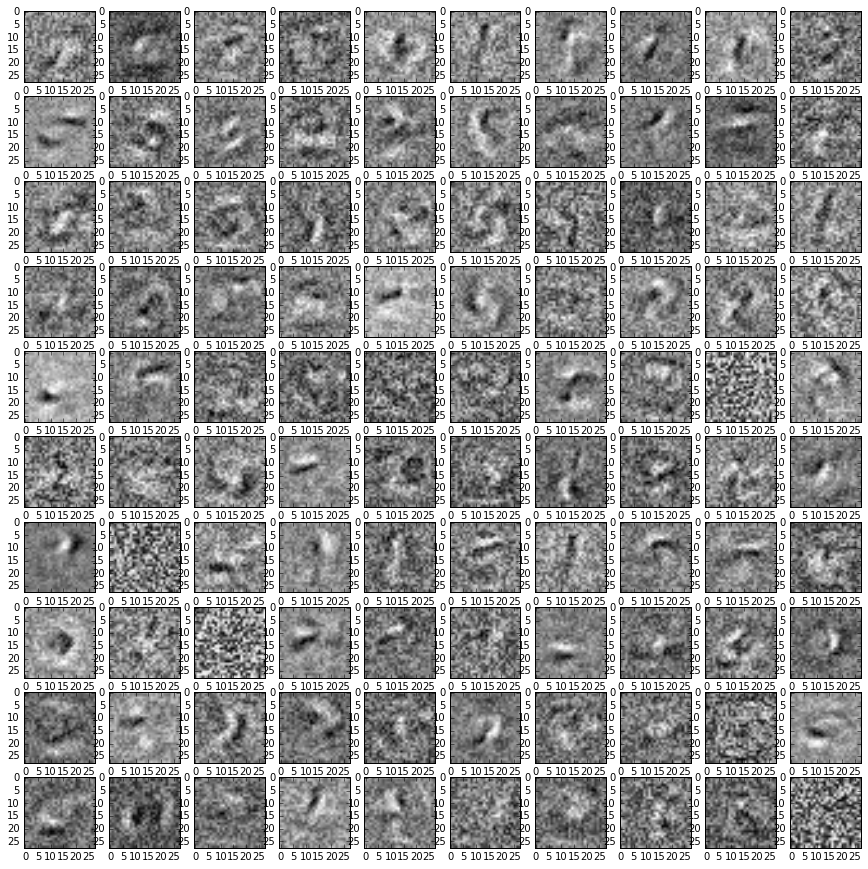

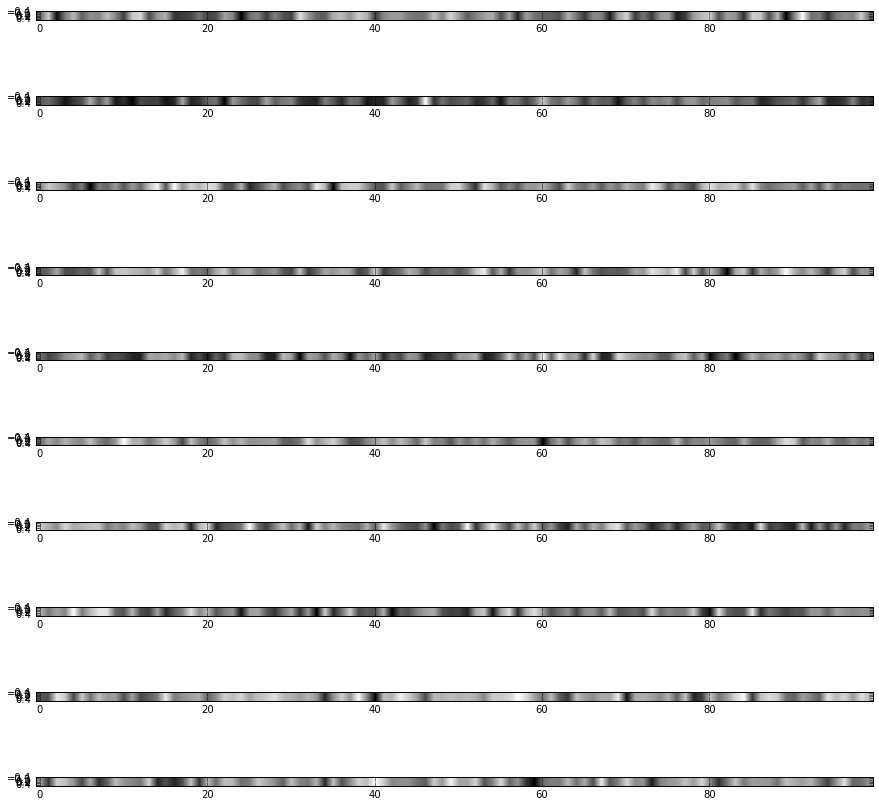

In [42]:
# Start training
gen_model()
nb_epoch = 200
history = model.fit(trainX, trainY, batch_size=128, nb_epoch=nb_epoch, verbose=0, validation_split=0.1)

# Show training summary
plot_training_history(history)
evaluate_model(model, testX, testY)
visualize_weight(model, fig_size=15)

# See difference of weights between with and without scaling

Weights with scale
layer1 : (min=-0.410714, max=0.356238, mean=0.000940, variance=0.003700)


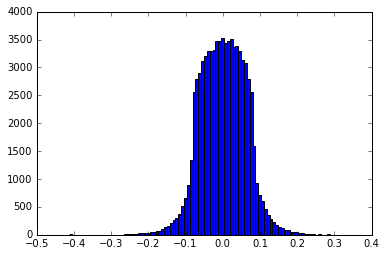

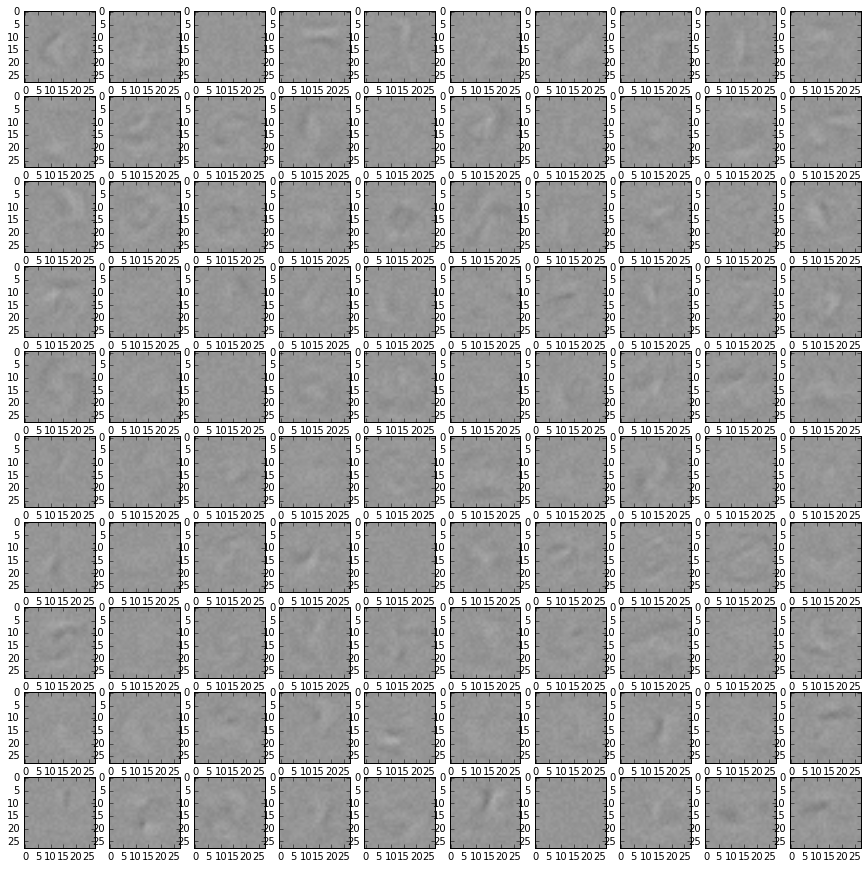

layer2 : (min=-1.094894, max=1.107429, mean=-0.004154, variance=0.129994)


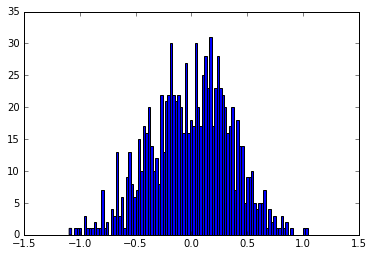

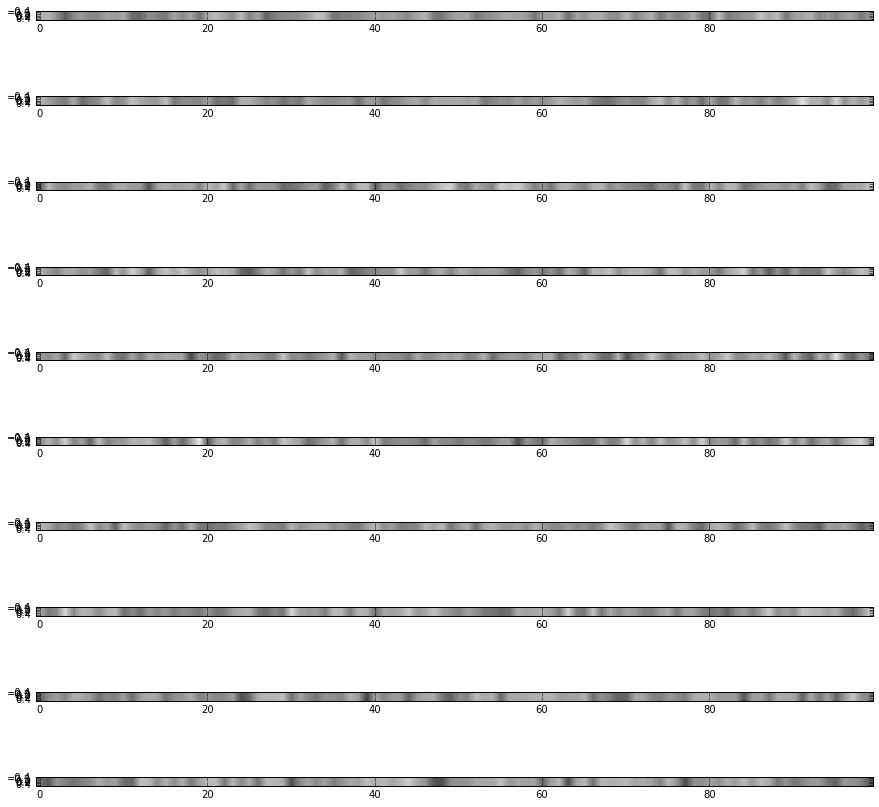

Weights without scale
layer1 : (min=-1.989635, max=1.403119, mean=-0.012906, variance=0.022070)


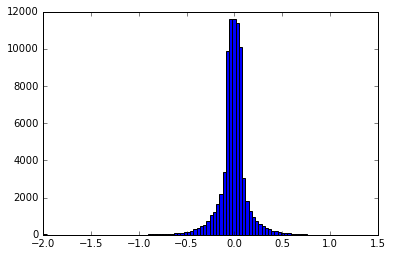

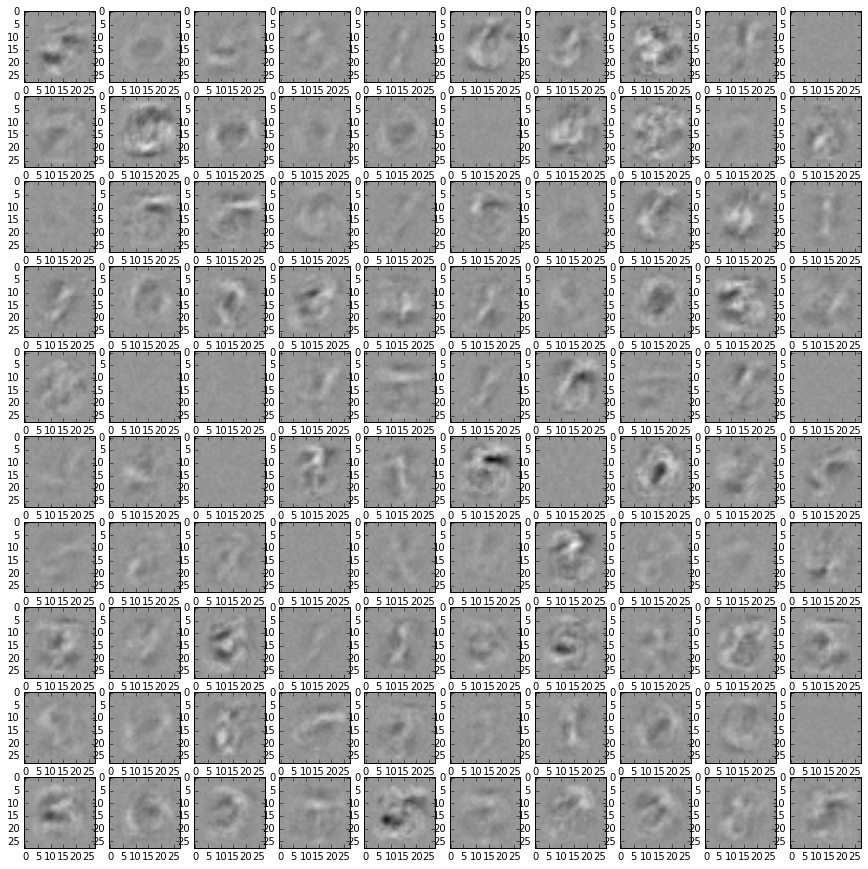

layer2 : (min=-1.851123, max=2.704725, mean=-0.000324, variance=0.375952)


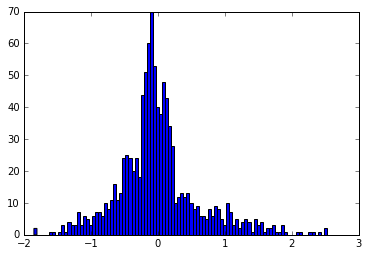

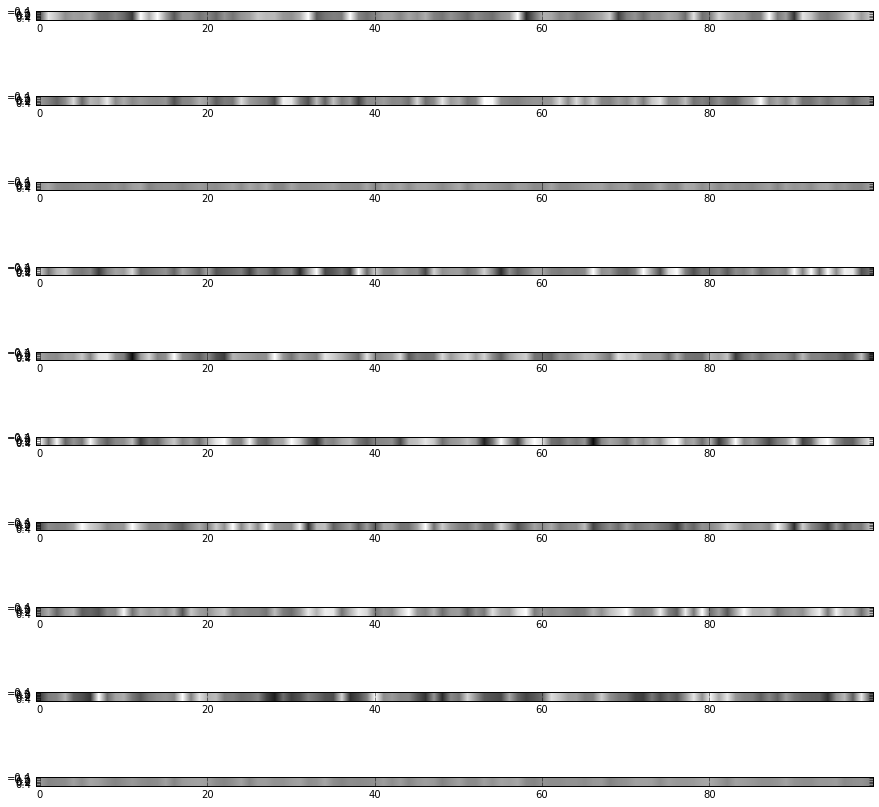

In [69]:
def examine_weight(model, minw1, maxw1, minw2, maxw2, fig_size):
    def examine(title, layer_idx, plt_w, plt_h, shape_w, shape_h):
        W1 =  model.layers[layer_idx].W.get_value(borrow=True).T
        print "%s : (min=%f, max=%f, mean=%f, variance=%f)" % (title, W1.min(), W1.max(), W1.mean(), W1.var())
        plt.hist(W1.reshape(W1.shape[0]*W1.shape[1]), bins=np.arange(W1.min(), W1.max(), (W1.max()-W1.min())/100))
        plt.figure(figsize=(fig_size, fig_size))
        for i in range(len(W1)):
            plt.subplot(plt_w, plt_h, i+1)
            plt.imshow(W1[i].reshape(shape_w, shape_h), cmap="gray")
            plt.clim(minw1, maxw1)
        plt.show()
    examine("layer1", 0, 10, 10, 28, 28)
    examine("layer2", 2, 10, 1, 1, 100)

models = [gen_model(weight_path) for weight_path in ["scale.hdf5", "notscaled.hdf5"]]
minw1 = min([w.layers[0].W.get_value(borrow=True).min() for w in models])
maxw1 = max([w.layers[0].W.get_value(borrow=True).max() for w in models])
minw2 = min([w.layers[2].W.get_value(borrow=True).min() for w in models])
maxw2 =max([w.layers[2].W.get_value(borrow=True).max() for w in models])
for title, target_model in zip(["Weights with scale", "Weights without scale"], [scaled, notscaled]):
    print title
    examine_weight(target_model, minw1, maxw1, minw2, maxw2, 15)

# Visualize activation

In [3]:
# Prepare visualize function
def record_activation(input_dim, activate_lambda):
    record = [None for i in range(input_dim)]
    for i in range(input_dim):
        X = np.zeros(input_dim)
        X[i] = 1
        record[i] = activate_lambda(X)
    return record
        
def visualize_activation(record, w, h):
    recordT = np.array(record).T
    for i in range(w*h):
        plt.subplot(w, h, i+1)
        plt.imshow(recordT[i].reshape(28,28), cmap="gray")
    plt.show()

def fetch_layer_from_model(model):
    layer1 = model.layers[0]
    activation1 = model.layers[1]
    layer2 = model.layers[2]
    activation2 = model.layers[3]
    return [layer1, activation1, layer2, activation2]

Weights with scale


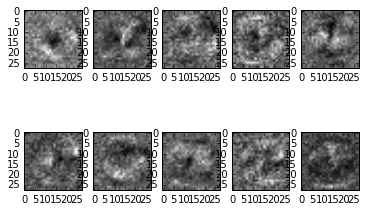

Weights without scale


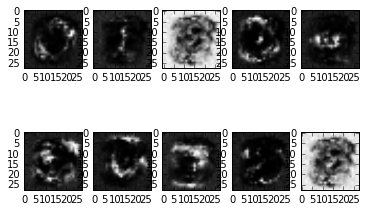

In [8]:
import theano.tensor as T

models = [gen_model(weight_path) for weight_path in ["scale.hdf5", "notscaled.hdf5"]]
for title, model in zip(["Weights with scale", "Weights without scale"], models):
    print title
    layer1, activation1, layer2, activation2 = fetch_layer_from_model(model)
    out_activation_record = record_activation(784, lambda x: T.nnet.softmax(layer2.call(activation1.call(layer1.call(x)))).eval())
    visualize_activation(out_activation_record, 2, 5)